# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to SVD.

## Exercise 1 (65 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (4 points)

In [7]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

# your code here

In [8]:
import pandas as pd 

pd.DataFrame(X).to_csv("data.csv", index=False, header=False)
pd.DataFrame(y).to_csv("target.csv", index=False, header=False)

b) Plot the singular value plot for a single example of the 0 digit (5 points)

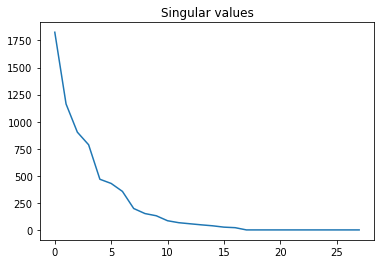

In [14]:
import numpy as np
import matplotlib.cm as cm

ex = X[1].reshape((28,28))
u, s, v = np.linalg.svd(ex, full_matrices=False)

fig, ax = plt.subplots()
ax.set_title("Singular values")
ax.plot(s)

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. (5 points)

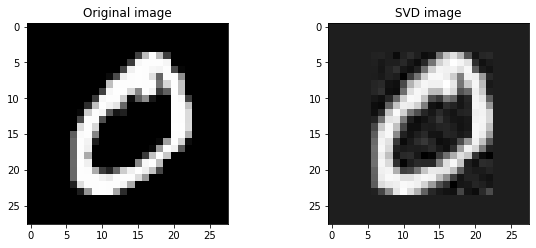

In [15]:
RANK = 7
scopy = s.copy()
scopy[RANK:] = 0

approx = u.dot(np.diag(scopy)).dot(v)

plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(ex, cmap = cm.Greys_r)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(approx, cmap = cm.Greys_r)
plt.title('SVD image')
_ = plt.subplots_adjust(wspace=0.5)
plt.show()

d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank. (10 points)

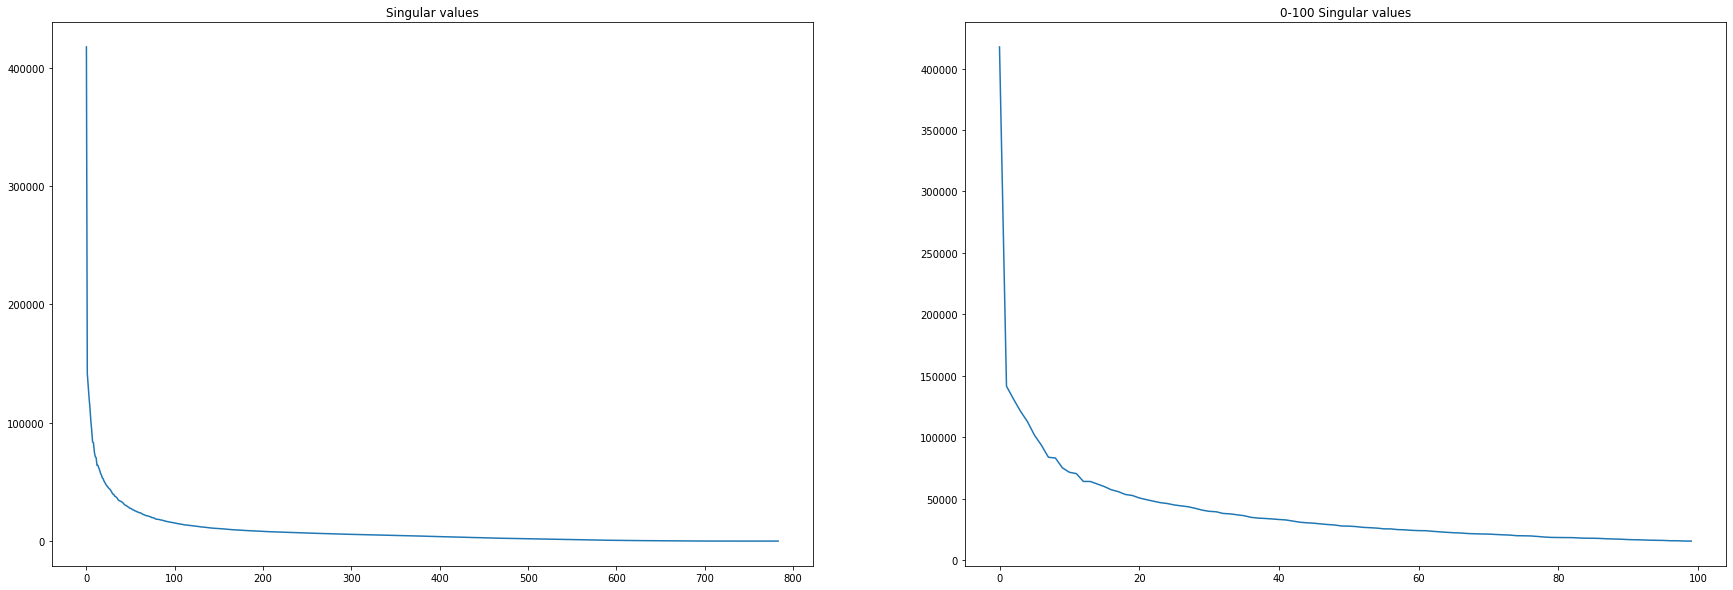

In [16]:
u, s, v = np.linalg.svd(X, full_matrices=False)

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.title("Singular values")
plt.plot(s)
plt.subplot(1,2,2)
plt.title("0-100 Singular values")
plt.plot(s[:100])
plt.show()

RANK = 10
s[RANK:] = 0

approx = u.dot(np.diag(s)).dot(v)
pd.DataFrame(approx).to_csv("dataApprox.csv", index=False, header=False, float_format="%.3f")

The elbow point nears x=10, so we have rank=10

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. (10 points)

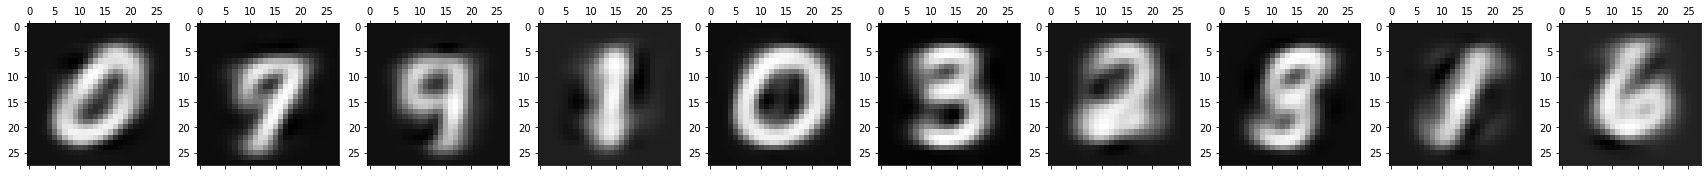

In [17]:
# your code here
from sklearn.cluster import KMeans

fig, axes = plt.subplots(1, 10, figsize=(30, 10))

kmeans = KMeans(n_clusters=10, random_state=0).fit(approx)
for ax, centroid in zip(axes, kmeans.cluster_centers_):
    ax.matshow(centroid.reshape(28, 28), cmap = cm.Greys_r)

f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe. (8 points)

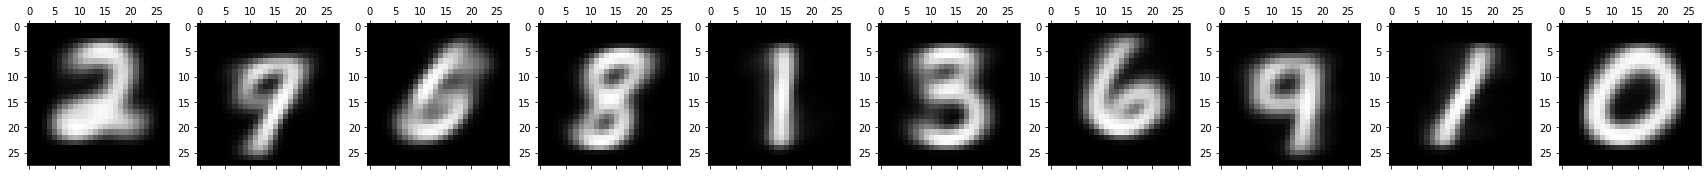

In [18]:
fig, axes = plt.subplots(1, 10, figsize=(30, 10))

kmeansOri = KMeans(n_clusters=10, random_state=0).fit(X)
for ax, centroid in zip(axes, kmeansOri.cluster_centers_):
    ax.matshow(centroid.reshape(28, 28), cmap = cm.Greys_r)

The original dataset has 5, but the approximation dataset doesn't have 5, but has two 0. 

g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. (8 points)

In [21]:
def disagreement_dist(P_labels, C_labels):
    distance = 0
    df = pd.DataFrame({'p': P_labels, 'c': C_labels})

    unique_p = df.p.unique()
    unique_c = df.c.unique()

    for vp in unique_p:
        diff = df[df.p != vp].c
        same = df[df.p == vp].c

        count_d = diff.value_counts()
        count_s = same.value_counts()

        for vc in unique_c:
            if vc in count_d and vc in count_s:
                distance += count_d[vc] * count_s[vc]

        # print(vp, count_d, count_s, distance, sep='\n')
        # print()
                
    for vc in unique_c:
        diff = df[df.c != vc].p
        same = df[df.c == vc].p

        count_d = diff.value_counts()
        count_s = same.value_counts()

        for vp in unique_p:
            if vp in count_d and vp in count_s:
                distance += count_d[vp] * count_s[vp]
    
        # print(vc, count_d, count_s, distance, sep='\n')
        # print()
    return distance / 2

# print(disagreement_dist([1,2,3],[3,2,3]))
print('SVD: ', disagreement_dist(kmeans.predict(approx), y))
print('Origin: ', disagreement_dist(kmeansOri.predict(X), y))


SVD:  305091779.0
Origin:  289492981.0


The disaggreement distance from e (SVD) is larger than f (Origin), which means SVD lost some information and leads to  more misclassification.

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset. (10 points)

In [22]:
dif = X - approx

i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. (5 points)

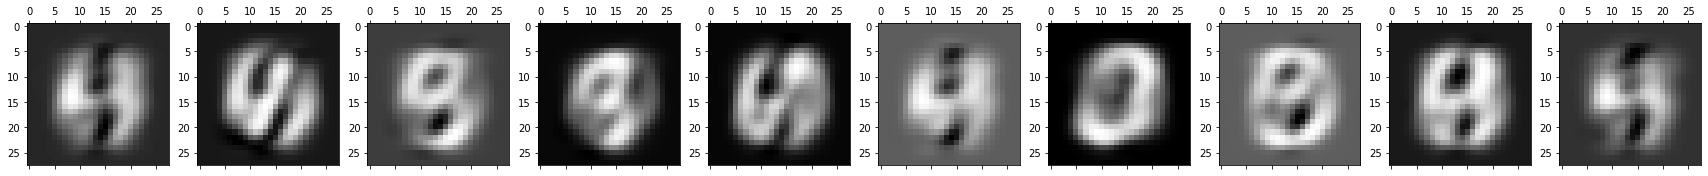

In [23]:
dist = np.linalg.norm(dif, axis=1)
top = (-dist).argsort()[:10]

fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for ax, index in zip(axes, top):
    ax.matshow(approx[index].reshape(28,28), cmap = cm.Greys_r)

## Exercise 2 (35 points)

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`). (3 points)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics', 'talk.politics.guns']
news_data = fetch_20newsgroups(subset='train', categories=categories)

b) Using the `SnowballStemmer`, stem the words in every article (10 points)

In [25]:
stemmer = SnowballStemmer("english")
corpus = []
for a in news_data['data']:
    article = []
    for w in a.split():
        article.append(stemmer.stem(w))
    corpus.append(' '.join(article))

c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. (7 points)

In [26]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

counter = CountVectorizer()
num = counter.fit_transform(corpus)
sum_count = pd.DataFrame(num.toarray()).apply(sum, axis=0)
vocab_dict = {name: count for name, count in zip(counter.get_feature_names_out(), sum_count)}
s = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)

print(s[:200])
print(s[-29800:-29500])

[('the', 28484), ('to', 14144), ('of', 13695), ('and', 11375), ('in', 10036), ('is', 7667), ('that', 6883), ('it', 6270), ('for', 5826), ('edu', 5013), ('you', 4846), ('from', 4586), ('be', 4261), ('on', 4163), ('this', 3936), ('have', 3615), ('are', 3347), ('with', 3077), ('as', 3033), ('not', 2949), ('or', 2881), ('was', 2764), ('they', 2663), ('if', 2641), ('but', 2608), ('at', 2492), ('subject', 2467), ('lines', 2351), ('com', 2281), ('organization', 2270), ('by', 2239), ('can', 2070), ('would', 1995), ('will', 1875), ('an', 1864), ('he', 1804), ('re', 1782), ('there', 1749), ('all', 1706), ('use', 1644), ('writes', 1634), ('what', 1633), ('about', 1617), ('do', 1610), ('one', 1566), ('articl', 1471), ('has', 1429), ('so', 1422), ('space', 1419), ('we', 1395), ('no', 1376), ('like', 1373), ('more', 1364), ('out', 1347), ('gun', 1320), ('some', 1285), ('get', 1265), ('my', 1262), ('ani', 1260), ('don', 1219), ('your', 1196), ('who', 1171), ('year', 1156), ('host', 1142), ('posting',

In [27]:
vectorizer = TfidfVectorizer(min_df=10, max_df=1000)
X = vectorizer.fit_transform(corpus)
pd.DataFrame(vectorizer.get_feature_names_out()).to_csv("tfidf.csv", index=False, header=False)

Through the CountVectorizer, I noticed that min_df should be 10, max_df should be 1000, to exclude some meaningless word.

d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly. (15 points)

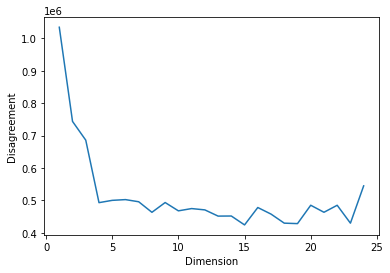

In [28]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

disagreement_distance = []

for k in range(1,25):
    dim_reduced_dataset = TruncatedSVD(k).fit_transform(X)
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()